# Waste Image Classification

# Section 0 - Introduction 

### Problem Statement

The recycling process requires people to sort their trash and their recycables into separate bins. However, most of the time, this is a tedious task. Additionally, recycling guidelines are oftentimes ignored, resulting in mixed recycling or even trash ending up in the recycling bins which can cause contamination and various other problems down the line. Also, poor judgement about whether an item is, for example, a tetra pack or a plastic can lead to the missclassification of waste. 

### Solution

A computer vision-based waste management system (waste sorting machine) would solve many of these problems. The system would be able to scan an item, identify its waste class and automatically ship the item to the correct bin from a centralized pool of recycable waste.

### Objective

The objective of this project is to train a model using images of different types of recycable waste from the training dataset 
- to accurately classify a given image from the validation dataset into one of the waste categories, and
- to accurately distinguish between different types of waste.

### Data

The dataset consists of more than 3000 samples. One sample presents an image of one or more items that belong to one type of recycable waste. 

I have downloaded the images from Google images and divided them into 9 folders, each representing one type of recycable waste. There are around 350 images of each type/in each folder. The data is stored on Kaggle and will need to be downloaded for use. 

# Section 1 - Setup

In [ ]:
# !pip install opendatasets

In [ ]:
# !pip install fastbook

In [34]:
from time import time

In [136]:
# Import needed libraries and modules

import opendatasets as od
from fastai.vision.all import *
from fastai.data.all import *
from fastai.metrics import accuracy 
from fastai.vision.widgets import ImageClassifierCleaner
# from fastai.vision.core import PILImage
from time import time
import os
import matplotlib.pyplot as plt
from random import randint
from pathlib import Path
import ipywidgets as widgets
import fastbook
fastbook.setup_book()
from fastbook import *

%matplotlib inline 

# Section 2 - Downloading the Image Data

To download the dataset, you must have an account on Kaggle. For further instructions on how to find your Kaggle username and Kaggle Key, refer to the link below:

https://www.analyticsvidhya.com/blog/2021/04/how-to-download-kaggle-datasets-using-jupyter-notebook/ 

In [ ]:
# Download the data from Kaggle
  
od.download("https://www.kaggle.com/sanjadrag24/waste-images")

# Section 3 - Preparing the Image Dataset

In [10]:
# The images were downloaded in the current working directory. Get the path to the images folder and view subfolders. 

path = Path('waste-images/Waste')
waste_folders = os.listdir(path)
waste_folders

['Aluminium',
 'Carton',
 'Glass',
 'Organic Waste',
 'Other Plastics',
 'Paper and Cardboard',
 'PET Plastics',
 'Textiles',
 'Wood']

In [11]:
# Verify that there are no corrupt images

corrupt_files = []
for folder in waste_folders:
    print(folder)
    files = get_image_files(path/folder)
    corrupt_files += verify_images(files)

print(f"\nNumber of corrupt files: {len(corrupt_files)}")

Aluminium
Carton
Glass
Organic Waste
Other Plastics
Paper and Cardboard
PET Plastics
Textiles
Wood

Number of corrupt files: 0


Text(0.5, 0, 'Count')

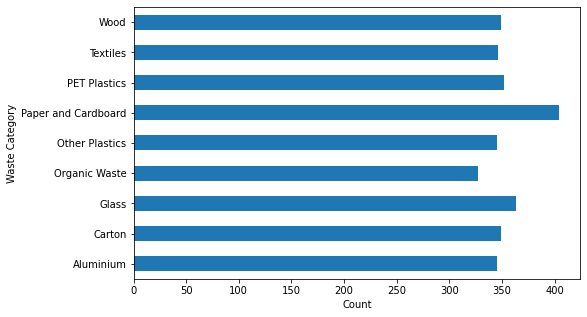

In [12]:
# Visualize data distribution 

count_images = []

for folder in waste_folders:
    files = get_image_files(path/folder)
    count_images.append(len(files))
        
plotdata = pd.DataFrame({"Count": count_images}, index=waste_folders)
plotdata.plot(kind="barh", figsize=(8,5), legend=False)
plt.ylabel("Waste Category")
plt.xlabel("Count")

We can see that the data is fairly distributed among the different waste classes. 

Before the images can be passed to the model, they need to be the same size. Because the images in the data set are different sizes, I resized them all to a size 128x128. 

Furthermore, I applied data augmentation to increase diversity in the training set. After testing several options, RandomResizedCrop proved to be the best resizing method for each item. For the batch transformations, I applied aug_transforms using default attribute values except for the two flip attributes. This is to avoid unrealistic representations of items in the training set - for example, items from the Paper and Cardboard, Aluminium, Carton, PET Plastics and Other Plastics can have text on them. Images with mirrored words or words written upside down would not represent the real instances of these items very well. 

In [54]:
# Transform items and split data

bs = 64
item_tfms = RandomResizedCrop(128, min_scale=0.3)  
batch_tfms = aug_transforms(do_flip = False, flip_vert = False) 
data = ImageDataLoaders.from_folder(path, valid_pct=0.2, bs=bs, item_tfms=item_tfms, batch_tfms=batch_tfms, 
                                    num_workers=0, seed=22)

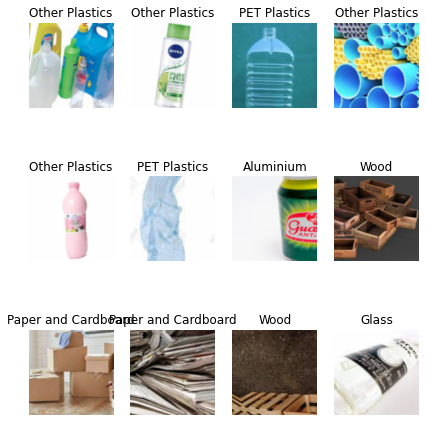

In [56]:
# Preview batch items

data.show_batch(max_n=12, nrows=3, figsize=(7, 8))

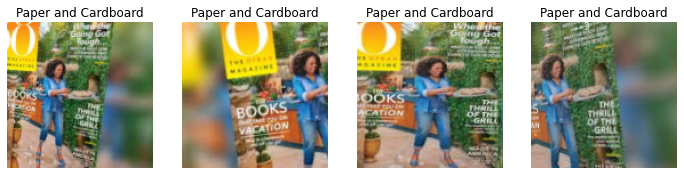

In [57]:
# View batch data augmentation on sample item

data.show_batch(max_n=4, nrows=1, unique=True)

# Section 4 - Training the Model

### Train model

I wanted to compare a few CNN architectures to see which one performs best. Due to the computation required to train and optimize several different models on this data, I only compared the models' performances (using the Accuracy and Error Rate metrics) based on the default hyperparameter values. I then continued training a single model - the one with the best performance. 

In [82]:
# Create function to centralize model performance metrics and scores of the different architectures

list_of_results = []

def update_results_list(model, model_name):
    model_values = [round(val,4) for val in model.validate()]
    model_values.insert(0, model_name)
    if model_values not in list_of_results:
        list_of_results.append(model_values)

##### 1) Resnet18 - stage 1

In [77]:
# Instantiate a learner using the resnet18 architecture

learn1 = cnn_learner(data, resnet18, metrics=[error_rate, accuracy], bn_final=True) 

In [78]:
# Fit learner to data

start = time()
learn1.fit_one_cycle(3)   
end = time()

print("Total Time:", round((end - start)/60, 2), "minutes")

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.810957,0.675682,0.229560,0.770440,01:30
1,1.295374,0.614033,0.174528,0.825472,01:38
2,1.093902,0.685694,0.166667,0.833333,01:37


Total Time: 4.76 minutes


In [79]:
# Save model

learn1.save('resnet18_stage1')

Path('waste-images/Waste/models/resnet18_stage1.pth')

In [83]:
# Capture model performance scores 

update_results_list(learn1, "resnet18")

##### 2) Resnet50 - stage 1

In [69]:
# Instantiate a learner using the resnet50 architecture

learn2 = cnn_learner(data, resnet50, metrics=[error_rate, accuracy], bn_final=True) 

In [70]:
# Fit learner to data

start = time()
learn2.fit_one_cycle(3)    
end = time()

print("Total Time:", round((end - start)/60, 2), "minutes")

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.357870,0.449291,0.158805,0.841195,05:44
1,0.980742,0.420900,0.103774,0.896226,05:59
2,0.825546,0.490886,0.100629,0.899371,06:01


Total Time: 17.77 minutes


In [72]:
# Save model

learn2.save('resnet50_stage1')

Path('waste-images/Waste/models/resnet50_stage1.pth')

In [84]:
# Capture model performance scores 

update_results_list(learn2, "resnet50")

##### 3)  VGG16 with Batchnorm - stage 1

In [64]:
# Instantiate a learner using the VGG16 architecture with batchnorm

learn3 = cnn_learner(data, vgg16_bn, metrics=[error_rate, accuracy], bn_final=True) 

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to C:\Users\Sanja's PC/.cache\torch\hub\checkpoints\vgg16_bn-6c64b313.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [65]:
# Fit learner to data

start = time()
learn3.fit_one_cycle(3)     
end = time()

print("Total Time:", round((end - start)/60, 2), "minutes")

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.746035,0.590980,0.163522,0.836478,08:32
1,1.242810,0.526493,0.135220,0.864780,08:31
2,1.049042,0.605944,0.136792,0.863208,08:46


Total Time: 25.85 minutes


In [66]:
# Save model

learn3.save('vgg16_bn_stage1')

Path('waste-images/Waste/models/vgg16_bn_stage1.pth')

In [85]:
# Capture model performance scores 

update_results_list(learn3, "vgg16_bn")

##### 4)  AlexNet - stage 1

In [86]:
# Instantiate a learner using the AlexNet architecture

learn4 = cnn_learner(data, alexnet, metrics=[error_rate, accuracy], bn_final=True) 

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to C:\Users\Sanja's PC/.cache\torch\hub\checkpoints\alexnet-owt-4df8aa71.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

In [88]:
# Fit learner to data

start = time()
learn4.fit_one_cycle(2)     
end = time()

print("Total Time:", round((end - start)/60, 2), "minutes")

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.190726,0.929031,0.286164,0.713836,00:26
1,1.138827,0.940336,0.281447,0.718553,00:28


Total Time: 0.92 minutes


I executed the above cell a second time to fit the model over two instead of three epochs. This is because the accuracy got worse in the third. This gave better results altogether the second time around. 

In [89]:
# Save model

learn4.save('alexnet_stage1')

Path('waste-images/Waste/models/alexnet_stage1.pth')

In [90]:
# Capture model performance scores 

update_results_list(learn4, "alexnet")

##### Compare Results

In [91]:
# Dump results into a structured table to compare performances

columns=["model", "valid_loss", "error_rate", "accuracy"]
compare_table = pd.DataFrame(list_of_results, columns=columns)
print(compare_table.to_string(index=False))

   model  valid_loss  error_rate  accuracy
resnet18      0.6857      0.1667    0.8333
resnet50      0.4909      0.1006    0.8994
vgg16_bn      0.6059      0.1368    0.8632
 alexnet      0.9403      0.2814    0.7186


We can see that using the ResNet50 pretrained model gives the best results based both on the validation loss and error rate/accuracy. I proceeded with the resnet50 model. 

In [98]:
# Load model with best performance (which is the resnet50-based model) and resume training

learn = cnn_learner(data, resnet50, metrics=[error_rate, accuracy], bn_final=True) 
learn.load('resnet50_stage1')

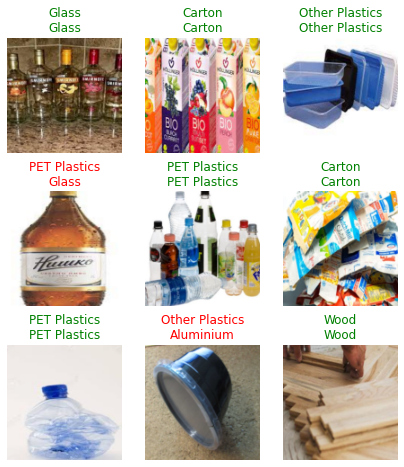

In [99]:
learn.show_results(figsize=(7, 8))

In the next section I have optimized the learning rate. To find the optimal learning rate, I needed to unfreeze/unlock all the layers in the network. 

c:\users\sanja's pc\appdata\local\programs\python\python37\lib\site-packages\fastai\callback\schedule.py:270: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(val, idx, 'ro', label=nm, c=color)


Total Time: 16.1 minutes


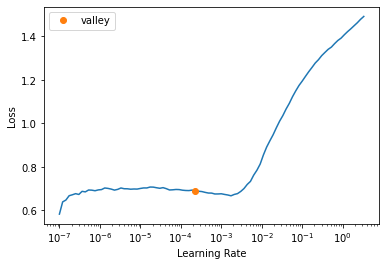

In [100]:
# Find optimal learning rate

start = time()
learn.unfreeze() 
learn.lr_find()
end = time()
print("Total Time:", round((end - start)/60, 2), "minutes")

We can see that the loss starts to decrease until it reaches the minimum somewhere in between 1e-3 and 1e-2, and starts to increase again. There is only a slight downward trend between 1e-5 and 1e-3, so I chose a point around the middle of that range, which is 3.25e-5.

In [103]:
# Fit learner using optimal learning rate range

start = time()
learn.fit_one_cycle(1, 3.25e-5)
end = time()
print("Total Time:", round((end - start)/60, 2), "minutes")

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.433866,0.426408,0.078616,0.921384,06:52


Total Time: 6.88 minutes


In [104]:
# Save model

learn.save('resnet50_stage2')

Path('waste-images/Waste/models/resnet50_stage2.pth')

I have tried going back to stage1 of the model and retraining it using a different number of epochs and other hyperparameter values, but the accuracy started decreasing and the model overfitting. I think this is a good a result and will export this model for deployment.

In [110]:
# Export model for deployment

learn.load('resnet50_stage2')
learn.export('waste_classification_model.pkl')

### Test model

In [115]:
# Take a look at the validation dataset

print("Number of classes:", data.valid.c)
print("Size of dataset:", len(data.valid_ds))

Number of classes: 9
Size of dataset: 636


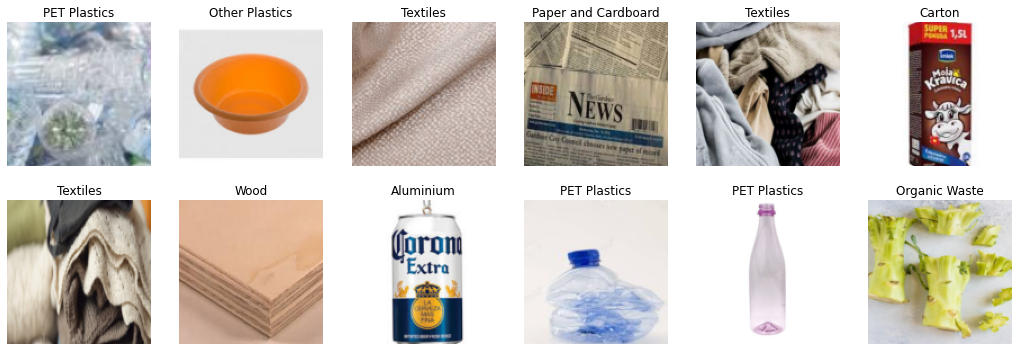

In [116]:
data.valid.show_batch(max_n=12, nrows=2)

The waste/item on this photo was classified as Textiles with a probability of 0.7981.


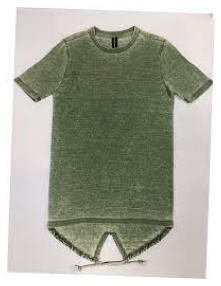

In [125]:
# Return predicted class, label and class probability for a randomly selected item from the validation dataset.

img_index = randint(0, len(data.valid_ds))
img = data.valid_ds[img_index][0]
img.show()

prediction, idx, probability = learn.predict(img)
print(f"The waste/item on this photo was classified as {prediction} with a probability of {max(probability):0.4f}.")

# Section 5 - Interpretation

<Figure size 1440x1440 with 0 Axes>

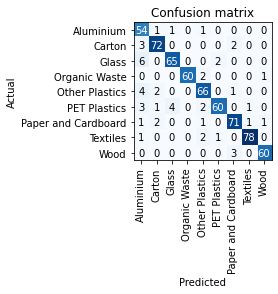

<Figure size 1440x1440 with 0 Axes>

In [152]:
# Instantiate the ClassificationInterpretation class

interpretation = ClassificationInterpretation.from_learner(learn)
interpretation.plot_confusion_matrix()

The highest number of false predictions occured within the PET Plastics category.

In [22]:
# See most confused waste images for a closer look

interpretation.most_confused(min_val=5)

[('PET Plastics', 'Glass', 18),
 ('Other Plastics', 'Aluminium', 15),
 ('Other Plastics', 'Carton', 15),
 ('Wood', 'Paper and Cardboard', 13),
 ('Glass', 'Aluminium', 12),
 ('Paper and Cardboard', 'Carton', 10),
 ('PET Plastics', 'Aluminium', 7),
 ('Wood', 'Textiles', 7),
 ('Paper and Cardboard', 'Textiles', 5)]

The confusion between PET plastics and glass are at the top of the list. This may reflect actual difficulties in differentiating between clear plastics and glass soley based on their visual appearance. But why is the model confusing other categories? 

Other potential causes of the errors in the predictions can relate to problems with the model, as well as problems with the dataset. To explore the latter, I will take a look at the images with the highest loss in the dataset. Images with the highest loss are the ones that were incorrectly classified with a high level of confidence (probability close to 1).  

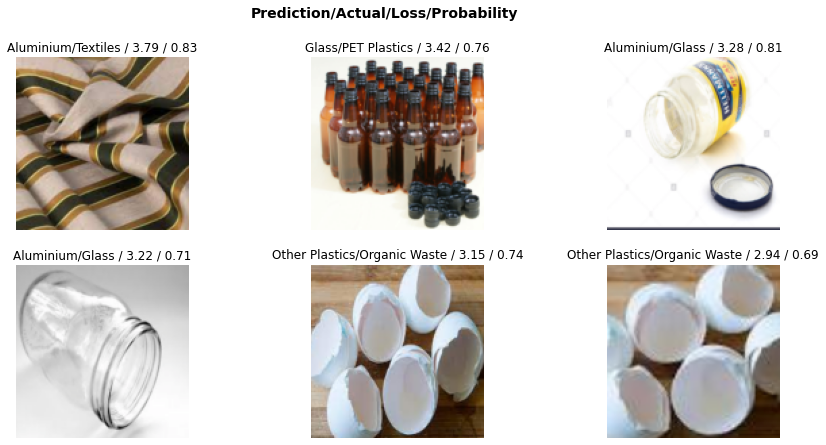

In [130]:
# Show images in `top_losses` along with their prediction, actual, loss, and probability.

interpretation.plot_top_losses(6, nrows=2, figsize=(15,7))

While the first prediction error doesn't make sense, I can somewhat see why the model made confusing predictions for the other pictures. For example, the Glass and PET Plastics confusion is understandable, as plastic and glass bottles can often have a very similar shape and colour. Also, the white eggshells do look like plastic bowls.

We can see that I also have some duplicate images in the dataset. I inspected the dataset for other top losses to consider additional data cleaning. 

# Section 6 - Data Cleaning and Retraining of Model

In [131]:
# View items with highest loss by category

cleaner = ImageClassifierCleaner(learn) 
cleaner

In [40]:
# Delete confusing images from dataset 

# for idx in cleaner.delete(): cleaner.fns[idx].unlink() 

The duplicate image above seems to be an isolated case. I haven't found any other issues with the images, so I did not perform any additional data cleaning to avoid having to retrain the model only because of minimal changes to the dataset. 

# Section 7 - Deployment and Application

While the test and validation sets were built from images downloaded online, I tested the model on photos of recycable items that I have taken myself. To deploy the model, I created a simple GUI (for uploading and classifying the photos) to simulate components of a waste sorting machine. 

In [149]:
# Create GUI for uploading and classifying photos of waste

# Create upload widget

lbl_upload_button = widgets.Label()
lbl_upload_button.value = "Upload photo of item"

uploader = widgets.FileUpload(description="Upload photo")


# Create classification widget

lbl_classify_button = widgets.Label()
lbl_classify_button.value = "Classify item into waste category"

run_btn = widgets.Button(description="Classify")

def on_click_classify(change):
    uploaded_img = PILImage.create(uploader.data[0])
    uploaded_img.show()
    prediction, idx, probability = model_inf.predict(uploaded_img)
    
    print(60*"_", "\n")
    print(f"Waste category: {prediction}")
    print(f"Probability that this belongs to {prediction} is: {max(probability):0.4f}")
    
run_btn.on_click(on_click_classify)

In [144]:
# Load classification model / inference learner from the exported file

model_inf = load_learner('./waste_classification_model.pkl')

____________________________________________________________ 

Waste category: Glass
Probability that this belongs to Glass is: 0.7495


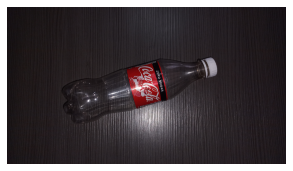

____________________________________________________________ 

Waste category: Paper and Cardboard
Probability that this belongs to Paper and Cardboard is: 0.7355


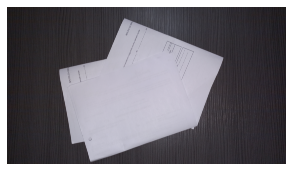

____________________________________________________________ 

Waste category: Carton
Probability that this belongs to Carton is: 0.6741


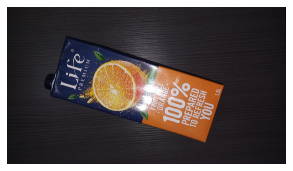

____________________________________________________________ 

Waste category: Glass
Probability that this belongs to Glass is: 0.5143


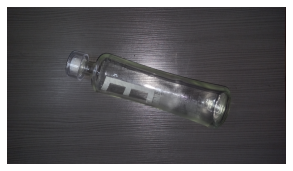

____________________________________________________________ 

Waste category: Carton
Probability that this belongs to Carton is: 0.7993


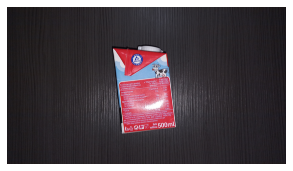

____________________________________________________________ 

Waste category: Aluminium
Probability that this belongs to Aluminium is: 0.8511


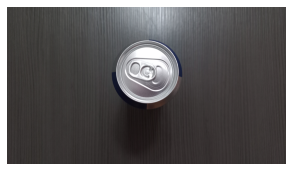

____________________________________________________________ 

Waste category: Aluminium
Probability that this belongs to Aluminium is: 0.8161


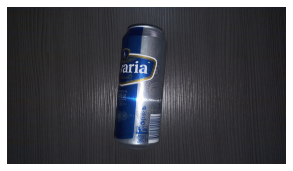

____________________________________________________________ 

Waste category: Paper and Cardboard
Probability that this belongs to Paper and Cardboard is: 0.3272


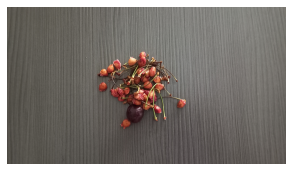

In [150]:
# Finalize GUI by putting all the above elements together

widgets.VBox([lbl_upload_button, uploader, lbl_classify_button, run_btn])

We can see that the model classified 6/8 images correctly.